In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# 14.1 시각 피질구조

뉴런들이 시야의 일부 범위 안에 있는 시각 자극에만 반응한다는 사실을 확인함.

뉴런의 수용장들은 서로 겹칠 수 있어서, 합치면 전체 시야를 감싸게 됨

# 14.2 합성곱 층

첫번째 합성곱 층의 뉴런은 입력 이미지의 모든 픽셀에 연결되는 것이 아니라 합성곱 층 뉴런의 수용장 안에 있는 픽셀에만 연결됨

두번째 합성곱 층에 있는 뉴런은 첫번째 층의 작은 사각영역 안에 위치한 뉴런에 연결

이러한 구조는 네트워크가 첫번째 층에서는 작은 저수준 특성에 집중하고, 다음 층으로 갈 수록 더 큰 고수준 특성으로 조합해나가도록 해줌

스트라이드(한 수용장과 다음 수용장 사이의 간격)을 두어 큰 입력층을 작은 층에 연결되게 하여 계산의 차원을 낮출 수 있음

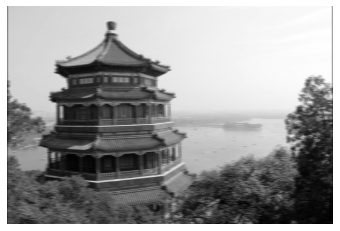

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# 샘플 이미지를 로드합니다.
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 2개의 필터를 만듭니다.
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선
filters[3, :, :, 1] = 1  # 수평선

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # 첫 번째 이미지의 두 번째 특성맵을 그립니다.
plt.axis("off") # 책에는 없습니다.
plt.show()

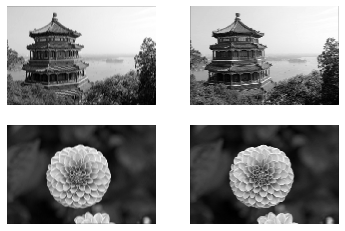

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

## 14.2.1 필터

In [5]:
def crop(images):
    return images[150:220, 130:250]

그림 저장 china_original


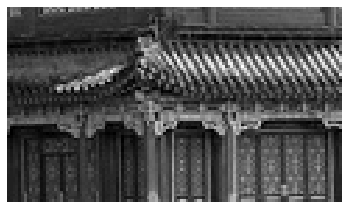

그림 저장 china_vertical


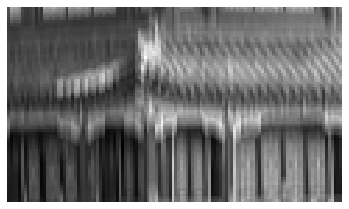

그림 저장 china_horizontal


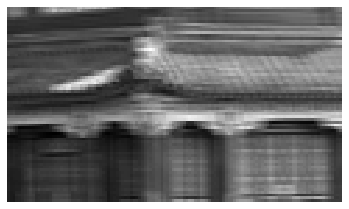

In [6]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

순서대로 원본 이미지와 수직필터, 수평필터를 적용한 이미지

수직(수평)필터는 수직(수평)선만 강조되고 나머지는 희미해짐

전체 뉴런에 적용된 하나의 필터는 하나의 특성맵(feature map)을 생성.

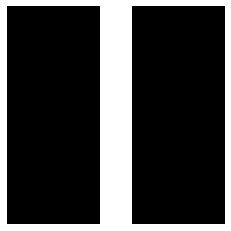

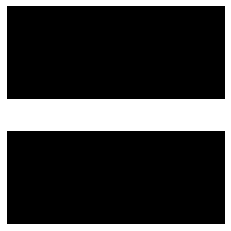

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## 14.2.2 여러가지 특성맵 쌓기

하나의 합성곱 층이 input 이미지에 여러 필터를 동시에 적용하여 input에 있는 여러 특성을 감지할 수 있음

입력 이미지는 컬러 채널마다 하나씩 여러 서브층으로 구성되기도 함.

일반적으로는 RGB(빨강, 초록, 파랑) 세가지이지만 위성이미지는 가시광선 이외에도 적외선 같은 다른 빛이 기록되기 때문에 여러개의 층을 가질 수 있음

## 14.2.3 텐서플로 구현

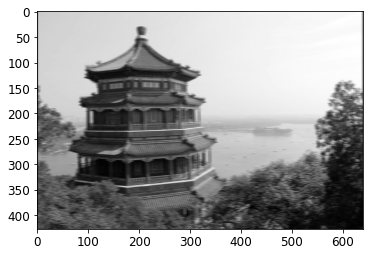

In [8]:
from sklearn.datasets import load_sample_image

# 이미지 픽셀값 0~255를 0~1로 가지도록 스케일링
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255

images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 두개의 7 by 7 필터를 만드는데, 하나는 가운데 흰 수직선을, 다른 하나는 가운데 흰 수평선으로 구성
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1   # 수직선
filters[3, :, :, 1] = 1   # 수평선

# 이 두 필터를 이미지에 적용.
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0, :, :, 1], cmap='gray')
plt.show()

In [9]:
# keras.layers.Conv2D를 이용한 예시

np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

In [10]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

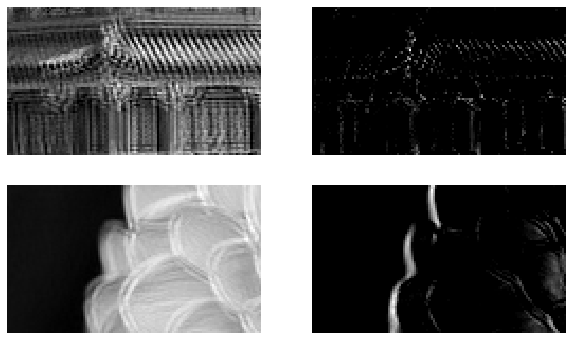

In [11]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [12]:
conv.set_weights([filters, np.zeros(2)])

In [13]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

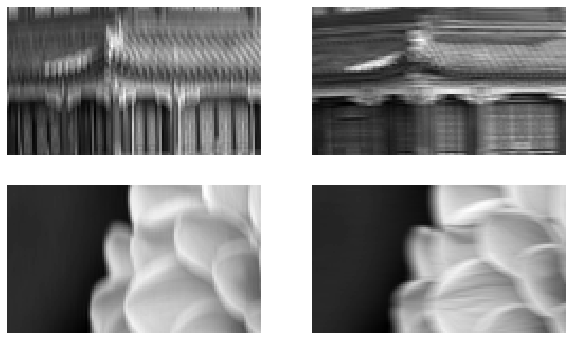

In [14]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

### Valid 패딩 vs SAME 패딩

- VALID : 합성곱 층에 제로 패딩을 사용하지 않음. 즉 스트라이드의 길이에 따라 일부 끝의 데이터가 유실될 수 있음

- SAME : 합성곱 층에 제로패딩을 사용. 부족한 칸 수 만큼 패딩(빈 공간)을 추가하여 필터링

In [15]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [16]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [17]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [18]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# conv_same의 가중치를 생성하기 위해 build() 메서드를 호출해야 합니다.
conv_same.build(tf.TensorShape(images.shape))

# conv_valid의 가중치를 conv_same으로 복사합니다.
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# 14.3 풀링 층

풀링 층의 목적은 계산량과 메모리 사용량, 파라미터 수를 줄이기 위해 입력 이미지의 subsample(축소본)을 만듬

풀링 층은 이전과 동일하게 크기, 스트라이드, 패딩 유형 등을 지정해주어야 하지만 풀링 뉴런은 가중치가 없음, 즉 최대나 평균같은 합산함수를 사용해 입력함수를 더하는 것이 전부

MaxPooling층이 대표적인 풀링 층(각 수용장에서 가장 큰 입력값만 다음 층으로 전달됨)

### MaxPooling

In [19]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [20]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

그림 저장 china_max_pooling


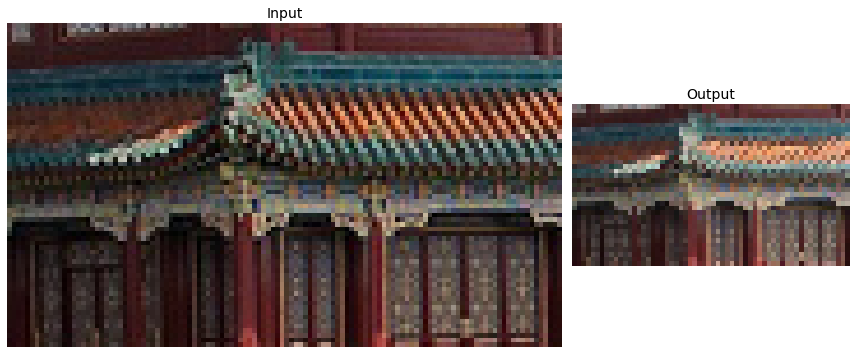

In [21]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

작은 변화에 일정 수준의 불변성을 가지기 때문에, 분류 작업처럼 예측이 작은 부분에서 영향을 받지 않는 경우 유용할 수 있음

하지만 이 층은 매우 파괴적(2x2 커널을 사용하면 면적이 1/4로 줄어들기 때문에 입력값의 75%를 잃음)

또한 어떤 상황에서는 불변성이 필요하지 않고, 등변성이 목표인 경우도 존재

Average Pooling 층도 존재하고, 평균을 계산하면 최댓값을 계산하는 것보다 정보손실이 적긴 하지만, MaxPooling은 의미없는 것을 모두 제거하고 가장 큰 특징만 유지하기 때문에 일반적으로 가장 효과적

## 깊이 방향(depth-wise) 풀링

MaxPooling과 AvgPooling은 공간 차원이 아니라 깊이차원으로도 수행될 수 있음

동일 패턴이 회전된 데이터의 경우, depthwise 풀링 층은 회전에 상관없이 동일한 출력을 만들 수 있다

In [22]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [23]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

또는 `Lambda` 층을 사용합니다:

In [24]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

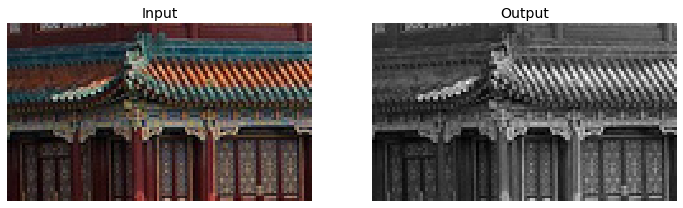

In [25]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()

## 평균 풀링

In [26]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [27]:
output_avg = avg_pool(cropped_images)

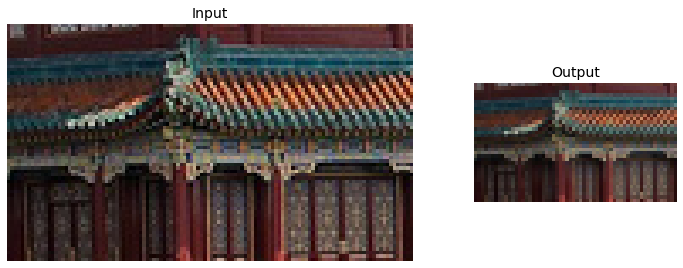

In [28]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

## 전역 평균 풀링

각 특성 맵의 평균을 계산하기 때문에 매우 파괴적이지만 출력층에는 유용할 수 있음

In [29]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [30]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

# 14.4 CNN 구조

일반적인 CNN은 합성곱 층을 몇 개 쌓고(각각 ReLU 층을 그 뒤에 놓고) 그 다음 풀링 층을 쌓고, 그 당므 또 합성곱층을 몇개 쌓고, 또 풀링층을 쌓는 형식

네트워크를 통과하여 진행할수록 이미지는 점점 작아지지만, 합성곱 층 때문에 일반적으로 점점 더 깊어짐

In [31]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [33]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),      
         # 7x7 필터 64개로 구성. 이미지가 28 x 28 크기이고 하나의 컬러채널이므로 28, 28, 1로 차원 지정
    keras.layers.MaxPooling2D(2),       # 풀링 크기가 2인 풀링층을 추가하여 공간방향 차원을 절반으로 줄임
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),      # Dense 층에는 1D 배열을 넣어야하므로 Flatten()을 통해 2D 배열을 1D 배열화
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [34]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # 새로운 이미지처럼 사용합니다
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 271s 157ms/step - loss: 0.7275 - accuracy: 0.7425 - val_loss: 0.3925 - val_accuracy: 0.8596
Epoch 2/10
1719/1719 [==============================] - 283s 165ms/step - loss: 0.4346 - accuracy: 0.8529 - val_loss: 0.3526 - val_accuracy: 0.8726
Epoch 3/10
1719/1719 [==============================] - 269s 156ms/step - loss: 0.3734 - accuracy: 0.8720 - val_loss: 0.3314 - val_accuracy: 0.8780
Epoch 4/10
1719/1719 [==============================] - 329s 192ms/step - loss: 0.3376 - accuracy: 0.8867 - val_loss: 0.2907 - val_accuracy: 0.8906
Epoch 5/10
1719/1719 [==============================] - 343s 200ms/step - loss: 0.3170 - accuracy: 0.8931 - val_loss: 0.2863 - val_accuracy: 0.8968
Epoch 6/10
1719/1719 [==============================] - 334s 194ms/step - loss: 0.2962 - accuracy: 0.8992 - val_loss: 0.3093 - val_accuracy: 0.8890
Epoch 7/10
1719/1719 [==============================] - 335s 195ms/step - loss: 0.2805 - accuracy: 0.9044 - val_

## 14.4.1 LeNet-5

tanh 활성화함수를 바탕으로 합성곱 -> 평균풀링을 3번 반복하다 두개의 Dense층으로 연결.

마지막 출력층은 RBF 활성화함수 사용

## 14.4.2 AlexNet

처음으로 합성곱 층 위에 풀링을 쌓지않고 바로 합성곱 층 끼리 쌓음

합성곱층과 최대풀링층이 섞여있음

과대적합을 줄이기 위해 드롭아웃 비율을 50%로 설정하였고, 훈련 이미지를 랜덤하게 여러 간격으로 이동하거나 뒤집고 조명을 바꾸는 등 데이터 증식 사용

## 14.4.3 GoogLeNet

'인셉션 모듈' 이라는 서브 네트워크를 가지고 있어서 훨씬 효과적으로 파라미터를 사용

처음 주입된 input 값이 복사되어 네 개의 다른 층으로 주입되고, 최종적으로 깊이방향(axis=3)으로 연결되어 모든 층의 출력을 연결

## 14.4.4 VGGNet

2개 또는 3개의 합성곱 층 뒤에 풀링층이 나오고 다시 2개 또는 3개의 합성곱 층과 풀링 층이 등장하는 방식

## 14.4.5 ResNet

스킵 연결(또는 숏컷 연결) 방법을 통해 어떤 층에 주입되는 신호가 상위 층의 출력에도 전해지는 기법을 사용

일반적인 신경망을 초기화할 때는 가중치가 0에 가깝기 때문에 네트워크도 0에 가까운 값을 출력하지만,

스킵 연결을 추가하면 이 네트워크는 입력과 같은 값을 출력. 즉 초기에는 항등함수를 모델링하기 때문에 훈련 속도가 매우 빨라짐

또한 스킵 연결을 많이 추가하면 일부 층이 아직 학습되지 않았더라도 네트워크는 훈련을 시작할 수 있음. 스킵 연결 때문에 입력신호가 전체 네트워크에 손쉽게 영향을 미치게 됨

## 14.4.6 Xception

GoogLeNet과 ResNet의 아이디어를 합쳤지만 인셉션 모듈은 깊이별 분리 합성곱층(depthwise separable convolution layer)로 대체

## 14.4.7 SENet

원래 구조에 있는 모든 유닛에 SE 블록이라는 작은 신경망을 추가하여 성능을 향상

# 14.5 케라스를 사용해 ResNet-34 CNN 구현하기

In [38]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
                           keras.layers.BatchNormalization(),
                           self.activation,
                           keras.layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False),
                           keras.layers.BatchNormalization()]
        self.skip_layers = [keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                            keras.layers.BatchNormalization()]
        
        if strides > 1:
            self.skip_layers = [keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                               keras.layers.BatchNormalization()]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [39]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64

for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       78592     
 )                                                               
                                                      

# 14.6 케라스에서 제공하는 사전훈련된 모델 사용하기

keras.applications 패키지에 준비되어 있는 사전 훈련된 모델을 불러올 수 있음

아래 예시는 ResNet-50 모델을 불러오고 이미지넷 데이터셋에서 사전 훈련된 가중치까지 로드

In [41]:
# ResNet-50 모델 로드, ResNet-50 모델은 224 x 224 크기의 이미지를 받으므로 tf.image.resize()로 조정 필요

model = keras.applications.resnet50.ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 11s 0us/step


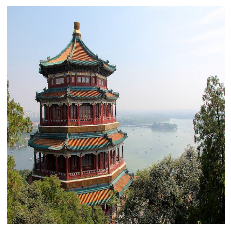

In [42]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


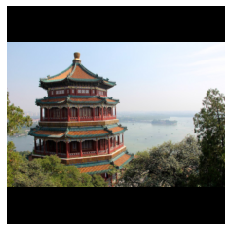

In [43]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

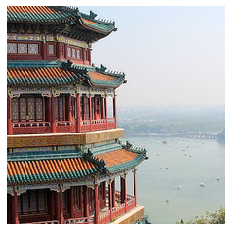

In [44]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

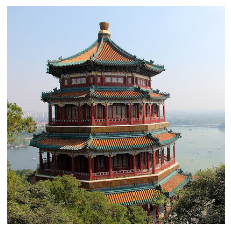

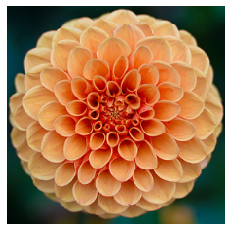

In [45]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

사전훈련된 모델을 이미지가 적절한 방식으로 전처리되었다고 가정하기 떄문에 모델마다 이미지를 전처리해주는 함수를 제공

In [46]:
# 원래 픽셀값이 0~255이기 때문에 이를 0~1로 바꾸어주는 전처리기능. 여기선 미리 0~1로 조정해두었기 때문에 다시 255를 곱함

inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [47]:
Y_proba = model.predict(inputs)

1/1 [==============================] - 1s 954ms/step


In [48]:
# decode_predictions() 함수를 통해 최상위 k개의 예측을 디코딩

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



이미지넷에 없는 이미지 클래스를 감지하는 분류기가 필요하다면 사전훈련된 모델을 사용해 전이학습 수행

# 14.7 사전훈련된 모델을 사용한 전이학습

In [49]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ytnal\tensorflow_datasets\tf_flowers\3.0.1.incompleteQ6I7WE\tf_flowers-train.tfrecord*...: …

Dataset tf_flowers downloaded and prepared to C:\Users\ytnal\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [50]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

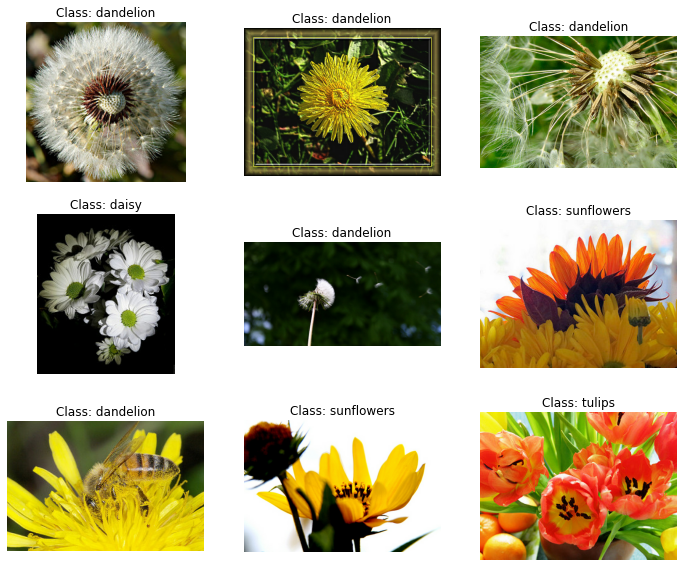

In [51]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [52]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [55]:
# 조금 더 정교한 전처리

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

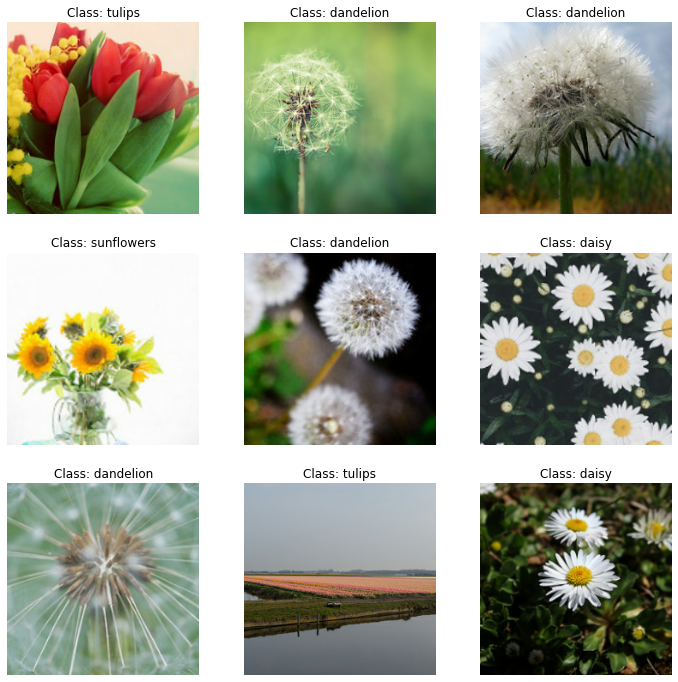

In [56]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

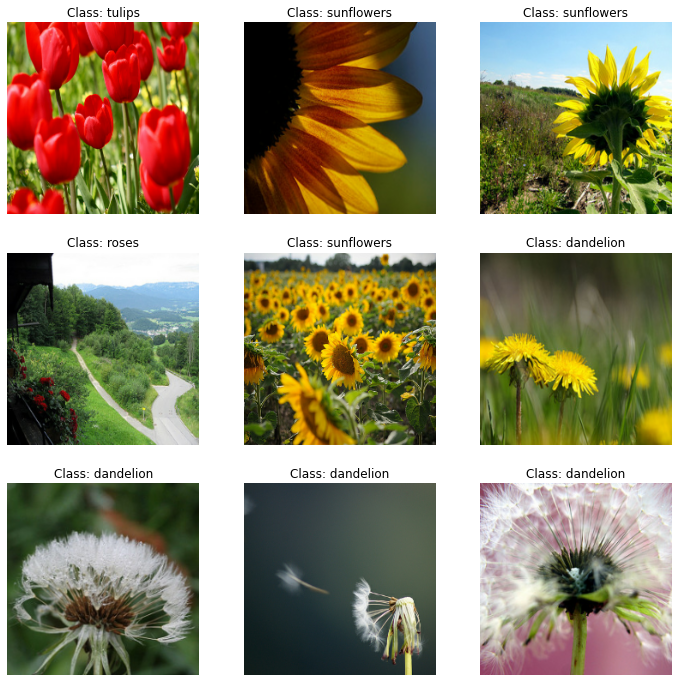

In [57]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [60]:
# Xception 모델 로드

base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)      # Global풀링은 1D 배열로 반환
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
# 훈련 초기에는 사전훈련된 층의 가중치를 동결하는 것이 좋음. 코드 오래걸려서 실행은 안시킴

for layer in base_model.layers:
    layer.trainable=False
    
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

# 14.8 분류와 위치 추정

물체의 위치를 추정하는 것은 회귀 작업으로 나타낼 수 있음.

물체 주위의 바운딩 박스를 예측하는 일반적인 방법은 물체 중심의 수평, 수직 좌표와 높이, 너비를 예측

In [62]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)

model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[0.8, 0.2], optimizer=optimizer, metrics=['accuracy'])

C:\Users\ytnal\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


바운딩 박스를 얼마나 잘 예측하는지 평가하는 지표는 IoU(Intersection over Union). 예측한 바운딩 박스와 타깃 바운딩 박스 사이에 중첩되는 영역을 전체 영역으로 나눈 값

tf.keras.metrics.MeanIoU 에 구현되어 있음

# 14.9 객체 탐지

하나의 이미지에서 여러 물체를 분류하고 위치를 추정하는 작업을 객체 탐지(Object Detection)이라고 함

이전에 주로 사용되던 방법은 이미지를 격자로 나누고 하나의 CNN이 모든 영역을 지나감. 이 CNN이 하나의 격자에서 이미지를 감지하면 다른 격자로 이동해서 같은 물체를 탐지하는 방식

이러한 CNN 방식은 매우 쉽지만 조금씩 다른 위치에서 동일한 물체를 여러번 감지하기 때문에 불필요한 바운딩 박스의 제거를 위해 사후처리(주로 NMS 방법)을 사용해야함

이러한 객체탐지 방법은 잘 동작하지만 CNN을 여러번 실행시켜야 하기 때문에 많이 느림 -> 완전 합성곱 신경망(FCN)으로 더 빠르게 가능

## 14.9.1 완전 합성곱 신경망

가장 상위층을 Dense 층이 아니라 합성곱층으로 바꿀 수 있음

유일한 차이는 Dense 층의 출력은 [배치 크기, 200]의 텐서이고 합성곱 층은 [배치크기, 1, 1, 200] 크기의 텐서

이러한 방식을 통해 cn은 이미지를 딱 한번만 처리할 수 있기 때문에 효율적

### MAP

객체 탐지에서 널리 사용하는 평가 지표(Mean Average Precision)

공정한 모델의 성능을 측정하는 방법은 최소 0% recall에서 얻을 수 있는 최대 정밀도, 그 다음 10%, 20%, ... , 100%까지 재현율에서의 최대 정밀도를 계산한 후, 이 최대 정밀도를 평균한 평균 정밀도(AP)를 계산하는데,

두 개 이상의 클래스가 있을 경우엔 각 클래스의 AP를 계산한 다음 평균 AP를 계산함. 이것이 mAP의 개념

객체 탐지 시스템에선 조금 복잡한데, 시스템이 정확한 클래스를 예측했지만 위치가 잘못되었다면 보통은 IOU 임계점을 지정해 판단

# 14.10 시맨틱 분할

각 픽셀을 픽셀이 속한 객체의 클래스로 분류(도로, 자동차, 사람, 건물 등)

조너선 롱의 2015년 논문에 따르면 사전훈련된 CNN을 FCN으로 변환하고, 입력 이미지에 적용하는 스트라이드는 32로 매우 크기 때문에 해상도를 32배로 늘리는 업샘플링 층을 추가